# Starting with Dummy Example

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor, Resize, ToPILImage, Compose, Normalize
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math

In [2]:
# 1. Define TokenShuffle/Unshuffle (simplified)
class TokenShuffle(nn.Module):
    def __init__(self, s=2):
        super().__init__()
        self.s = s  # shuffle window size
        
    def forward(self, x):
        """Input: (batch, seq_len, dim)"""
        b, n, d = x.shape
        x = x.view(b, n // (self.s**2), self.s**2 * d)
        return x

In [3]:
class TokenUnshuffle(nn.Module):
    def __init__(self, s=2):
        super().__init__()
        self.s = s
        
    def forward(self, x):
        """Input: (batch, seq_len, s²*dim)""" 
        b, n, d = x.shape
        return x.view(b, n * (self.s**2), d // (self.s**2))

In [4]:
img = Image.open("/kaggle/input/image-token/1000092692.jpg").convert("RGB")
transform = Compose([Resize((256, 256)), ToTensor()])
img_tensor = transform(img).unsqueeze(0)  # (1, 3, 256, 256)

In [5]:
img_tensor, img_tensor.shape

(tensor([[[[0.5255, 0.5725, 0.5176,  ..., 0.9255, 0.9255, 0.9216],
           [0.5608, 0.5608, 0.5490,  ..., 0.9255, 0.9255, 0.9216],
           [0.5725, 0.5490, 0.6157,  ..., 0.9255, 0.9255, 0.9255],
           ...,
           [0.7765, 0.8000, 0.7765,  ..., 0.7765, 0.7686, 0.7843],
           [0.7882, 0.7882, 0.7451,  ..., 0.8863, 0.8902, 0.8118],
           [0.7725, 0.7490, 0.7059,  ..., 0.8549, 0.9373, 0.9137]],
 
          [[0.3059, 0.4431, 0.3529,  ..., 0.8784, 0.8784, 0.8745],
           [0.3569, 0.4196, 0.3725,  ..., 0.8784, 0.8784, 0.8745],
           [0.3725, 0.3961, 0.4314,  ..., 0.8784, 0.8784, 0.8784],
           ...,
           [0.3882, 0.4235, 0.4078,  ..., 0.8078, 0.8039, 0.8196],
           [0.4039, 0.4118, 0.3725,  ..., 0.8706, 0.8824, 0.8157],
           [0.3882, 0.3686, 0.3216,  ..., 0.8275, 0.9059, 0.8980]],
 
          [[0.1725, 0.3765, 0.2588,  ..., 0.8314, 0.8314, 0.8275],
           [0.2275, 0.3529, 0.2627,  ..., 0.8314, 0.8314, 0.8275],
           [0.2392, 0.32

In [6]:
def image_to_patches(x, patch_size=16):
    """Convert image to non-overlapping patches"""
    b, c, h, w = x.shape
    x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
    return x.view(b, -1, c*patch_size*patch_size)  # (1, 256, 768)

# Create dummy tokens (pretend these came from VQGAN)
patches = image_to_patches(img_tensor)
tokens = patches  # (1, 256, 768) - 256 tokens of 768-dim

In [7]:
print(f"Image Shape: {img_tensor.shape}")
print(f"Image after patching: {patches.shape}")

Image Shape: torch.Size([1, 3, 256, 256])
Image after patching: torch.Size([1, 256, 768])


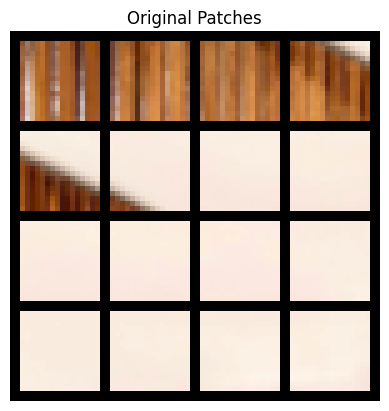

In [8]:
def show_patches(patches, title):
    """Display first 16 patches in a grid"""
    patch_grid = patches[0,:16].view(16, 3, 16, 16)
    grid_img = torchvision.utils.make_grid(patch_grid, nrow=4, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")
    plt.show()

show_patches(patches.view(1, 256, 3, 16, 16), "Original Patches")

In [9]:
shuffle = TokenShuffle(s=2)
shuffled = shuffle(tokens)
print(f"Shuffled shape: {shuffled.shape}")  # (1, 64, 3072)
# however 3072 is transformed to 768 or EMBED_DIM through an MLP

Shuffled shape: torch.Size([1, 64, 3072])


In [10]:
class DummyLLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(3072, 3072)
        
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

processed = DummyLLM()(shuffled)

In [11]:
unshuffle = TokenUnshuffle(s=2)
reconstructed = unshuffle(processed)
print(f"Reconstructed shape: {reconstructed.shape}")  # (1, 256, 768)

Reconstructed shape: torch.Size([1, 256, 768])


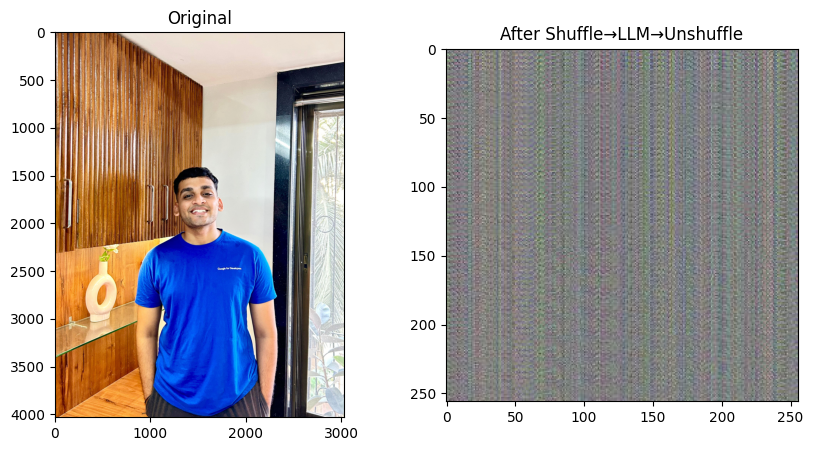

In [12]:
def patches_to_image(x, original_size=256):
    """Convert patches back to image"""
    b, n, d = x.shape
    patch_size = int((d//3)**0.5)
    x = x.view(b, n, 3, patch_size, patch_size)
    x = x.permute(0, 2, 1, 3, 4).contiguous()
    x = x.view(b, 3, original_size, original_size)
    return x

reconstructed_img = patches_to_image(reconstructed)
ToPILImage()(reconstructed_img[0]).save("reconstructed.jpg")

plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("Original")
plt.subplot(122); plt.imshow(Image.open("reconstructed.jpg"))
plt.title("After Shuffle→LLM→Unshuffle")
plt.show()

# Training TokenShuffleModel on flickr8

In [13]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from torchvision import transforms
from tqdm import tqdm

# 1. Load Dataset
dataset = load_dataset("tsystems/flickr8k", split='train[:1000]')  # First 1000 samples

README.md:   0%|          | 0.00/492 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

In [14]:
class LayerNorm(nn.Module):
    """Layer normalization module with learnable affine parameters."""
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        return self.gamma * (x - mean) / (var + self.eps).sqrt() + self.beta

In [15]:
class TokenShuffle(nn.Module):
    def __init__(self, s=2, latent_dim=4, hidden_dim=128):
        super().__init__()
        self.s = s
        self.norm = LayerNorm(latent_dim * s**2)
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim * s**2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Dropout(0.1)  # Add dropout for regularization
        )
        
    def forward(self, x):
        # x shape: (batch, channels, height, width)
        b, c, h, w = x.shape
        x = x.view(b, c, h//self.s, self.s, w//self.s, self.s)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.view(b, (h//self.s)*(w//self.s), c*self.s**2)
        x = self.norm(x)  # Normalize before MLP
        return self.mlp(x)

class TokenUnshuffle(nn.Module):
    def __init__(self, s=2, latent_dim=4, hidden_dim=128):
        super().__init__()
        self.s = s
        self.latent_dim = latent_dim
        self.norm = LayerNorm(latent_dim)
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, latent_dim * s**2),
            nn.Dropout(0.1)  # Add dropout for regularization
        )
        
    def forward(self, x):
        # x shape: (batch, seq_len, latent_dim)
        b, n, d = x.shape
        x = self.norm(x)  # Normalize before MLP
        
        # Process through MLP - expands features by s²
        x = self.mlp(x)  # (b, n, d*s²)
        
        # Calculate spatial dimensions
        spatial_size = int(n**0.5)  # This is the size of the grid before unshuffling
        
        # Reshape to spatial format with proper dimensions
        x = x.view(b, spatial_size, spatial_size, self.latent_dim, self.s, self.s)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        
        # Final reshape to proper image format
        h_out = w_out = spatial_size * self.s
        return x.view(b, self.latent_dim, h_out, w_out)

In [16]:
class PositionalEncoding(nn.Module):
    """Add positional encoding to token embeddings"""
    def __init__(self, dim, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

In [17]:
class Attention(nn.Module):
    """Simple self-attention layer"""
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

In [18]:
class TokenShuffleModel(nn.Module):
    def __init__(self, latent_dim=4, hidden_dim=128, num_heads=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.shuffle = TokenShuffle(s=2, latent_dim=latent_dim, hidden_dim=hidden_dim)
        self.unshuffle = TokenUnshuffle(s=2, latent_dim=latent_dim, hidden_dim=hidden_dim)
        
        # Text encoder projection with normalization
        self.text_proj = nn.Sequential(
            nn.Linear(768, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.LayerNorm(latent_dim)
        )
        
        # Positional encoding for spatial awareness
        self.pos_encoding = PositionalEncoding(latent_dim)
        
        # Self-attention for better feature mixing
        self.attention = Attention(latent_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(latent_dim)
        self.norm2 = nn.LayerNorm(latent_dim)
        
        # MLP block after attention
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, latent_dim),
            nn.Dropout(0.1)
        )
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
    def forward(self, images, text_embeddings):
        # Encode images to latents
        with torch.no_grad():
            latents = vqgan.encode(images).latent_dist.sample() * 0.18215  # (b,4,64,64)
        
        # Shuffle tokens
        shuffled = self.shuffle(latents)  # (b,n,d)
        
        # Process text embeddings
        text_feat = self.text_proj(text_embeddings.last_hidden_state)  # (b,77,d)
        
        # Global text feature (average pooling)
        text_global = text_feat.mean(dim=1, keepdim=True)  # (b,1,d)
        
        # Add text feature to all tokens through addition
        combined = shuffled + text_global
        
        # Add positional encoding
        combined = self.pos_encoding(combined)
        
        # Apply self-attention with residual connections and layer norm
        residual = combined
        combined = self.norm1(residual + self.attention(combined))
        
        # Apply MLP with residual
        residual = combined
        combined = self.norm2(residual + self.mlp(combined))
        
        # Unshuffle and decode
        unshuffled = self.unshuffle(combined)
        return unshuffled

In [19]:
!pip install diffusers transformers

In [20]:
device = torch.device("cuda")

In [21]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
vqgan = pipe.vae  # VQGAN is part of the VAE module in the pipeline

2025-05-10 06:12:19.929608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746857540.111151      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746857540.168503      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [22]:
text_encoder.requires_grad_(False)
vqgan.requires_grad_(False)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [23]:
class Flickr8kDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform or transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        caption = item['captions'][0] if isinstance(item['captions'], list) else item['captions']
        
        if self.transform:
            image = self.transform(image.convert("RGB"))
            
        return {
            'pixel_values': image,
            'input_ids': tokenizer(
                caption,
                padding='max_length',
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            ).input_ids[0]  # Remove batch dimension
        }

# Initialize tokenizer first
tokenizer = pipe.tokenizer

# Create dataset and dataloader
train_dataset = Flickr8kDataset(dataset)
dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda batch: {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'input_ids': torch.stack([x['input_ids'] for x in batch])
    }
)

In [24]:
model = TokenShuffleModel().to(device)

In [25]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import numpy as np

def train_model(model, dataloader, num_epochs=10, lr=5e-5, weight_decay=0.01, 
                use_amp=True, save_path='model_checkpoints'):
    """
    Optimized training loop for faster convergence
    
    Args:
        model: The TokenShuffleModel to train
        dataloader: DataLoader containing image-text pairs
        num_epochs: Number of training epochs
        lr: Learning rate
        weight_decay: Weight decay for regularization
        use_amp: Whether to use mixed precision training
        save_path: Directory to save model checkpoints
    """
    # Initialize optimizer with weight decay for regularization
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
    
    # Cosine learning rate schedule for better convergence
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(dataloader), eta_min=1e-6)
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler() if use_amp else None
    
    # Loss function
    criterion = torch.nn.MSELoss()
    
    # For tracking metrics
    best_loss = float('inf')
    running_loss = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move data to device
            images = batch['pixel_values'].to(device)
            text_inputs = {'input_ids': batch['input_ids'].to(device)}
            
            # Get text embeddings (only compute once)
            with torch.no_grad():
                text_embeddings = text_encoder(**text_inputs)
                target_latents = vqgan.encode(images).latent_dist.sample() * 0.18215
            
            # Mixed precision forward pass
            if use_amp:
                with autocast():
                    reconstructed_latents = model(images, text_embeddings)
                    loss = criterion(reconstructed_latents, target_latents)
                
                # Scale gradients and optimize
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                
                # Gradient clipping to prevent exploding gradients
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular forward pass without mixed precision
                reconstructed_latents = model(images, text_embeddings)
                loss = criterion(reconstructed_latents, target_latents)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
            # Track metrics
            current_loss = loss.item()
            epoch_losses.append(current_loss)
            running_loss.append(current_loss)
            
            # Calculate running average loss (over last 50 batches)
            running_avg = np.mean(running_loss[-50:]) if running_loss else 0
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{current_loss:.4f}",
                'avg_loss': f"{running_avg:.4f}",
                'lr': f"{scheduler.get_last_lr()[0]:.2e}"
            })
            
            # Optional: Save best model
            if (batch_idx + 1) % 100 == 0:
                avg_epoch_loss = np.mean(epoch_losses)
                if avg_epoch_loss < best_loss:
                    best_loss = avg_epoch_loss
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_loss,
                    }, f"{save_path}/best_model.pt")
        
        # End of epoch
        avg_epoch_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Average loss: {avg_epoch_loss:.4f}")
        
        # Save checkpoint at the end of each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(), 
            'loss': avg_epoch_loss,
        }, f"{save_path}/checkpoint_epoch_{epoch+1}.pt")
    
    return model

In [26]:
# Set up training parameters
batch_size = 4  # Adjust based on your GPU memory
initial_lr = 2e-5
total_epochs = 15  # Start with fewer epochs for testing

# Create directory for checkpoints
import os
os.makedirs('model_checkpoints', exist_ok=True)

# Train the model
trained_model = train_model(
    model=model,
    dataloader=dataloader,
    num_epochs=total_epochs,
    lr=initial_lr,
    weight_decay=0.01,
    use_amp=True  # Set to False if you encounter stability issues
)

# Save the final model
torch.save(trained_model.state_dict(), 'model_checkpoints/final_model.pt')

/tmp/ipykernel_31/1341429488.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None
Epoch 1/15:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_31/1341429488.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.9304, avg_loss=0.7169, lr=1.98e-05]


Epoch 1/15 completed. Average loss: 0.7262


Epoch 2/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.7056, avg_loss=0.6179, lr=1.92e-05]


Epoch 2/15 completed. Average loss: 0.6597


Epoch 3/15: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s, loss=0.5165, avg_loss=0.5599, lr=1.82e-05]


Epoch 3/15 completed. Average loss: 0.5940


Epoch 4/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.4413, avg_loss=0.5364, lr=1.69e-05]


Epoch 4/15 completed. Average loss: 0.5604


Epoch 5/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.5597, avg_loss=0.5477, lr=1.52e-05]


Epoch 5/15 completed. Average loss: 0.5405


Epoch 6/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.5262, avg_loss=0.5221, lr=1.34e-05]


Epoch 6/15 completed. Average loss: 0.5251


Epoch 7/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.6116, avg_loss=0.5080, lr=1.15e-05]


Epoch 7/15 completed. Average loss: 0.5122


Epoch 8/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4766, avg_loss=0.5070, lr=9.51e-06]


Epoch 8/15 completed. Average loss: 0.5021


Epoch 9/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.4619, avg_loss=0.5108, lr=7.56e-06]


Epoch 9/15 completed. Average loss: 0.4949


Epoch 10/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4132, avg_loss=0.4891, lr=5.75e-06]


Epoch 10/15 completed. Average loss: 0.4897


Epoch 11/15: 100%|██████████| 500/500 [04:02<00:00,  2.07it/s, loss=0.4556, avg_loss=0.4991, lr=4.14e-06]


Epoch 11/15 completed. Average loss: 0.4864


Epoch 12/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4527, avg_loss=0.4894, lr=2.81e-06]


Epoch 12/15 completed. Average loss: 0.4842


Epoch 13/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4861, avg_loss=0.4862, lr=1.82e-06]


Epoch 13/15 completed. Average loss: 0.4825


Epoch 14/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4863, avg_loss=0.4650, lr=1.21e-06]


Epoch 14/15 completed. Average loss: 0.4819


Epoch 15/15: 100%|██████████| 500/500 [04:02<00:00,  2.06it/s, loss=0.4961, avg_loss=0.4728, lr=1.00e-06]

Epoch 15/15 completed. Average loss: 0.4811


In [36]:
def generate(prompt, model, num_refinement_steps=10, guidance_scale=7.5):
    """Enhanced generation with iterative latent refinement"""
    # Text embeddings
    text_input = tokenizer(
        [prompt],
        padding='max_length',
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids)
        
        # Start with random latents (4x64x64)
        latents = torch.randn(1, 4, 64, 64).to(device)
        
        # Iterative refinement
        for _ in range(num_refinement_steps):
            # Process through model
            shuffled = model.shuffle(latents)
            
            # Project text embeddings
            text_proj = model.text_proj(text_embeddings.last_hidden_state)
            text_global = text_proj.mean(dim=1, keepdim=True)
            
            # Combine with guidance scale
            combined = shuffled + guidance_scale * text_global
            
            # Add positional encoding and process
            combined = model.pos_encoding(combined)
            residual = combined
            combined = model.norm1(residual + model.attention(combined))
            residual = combined
            combined = model.norm2(residual + model.mlp(combined))
            
            # Unshuffle and update latents
            unshuffled = model.unshuffle(combined)
            latents = 0.9 * latents + 0.1 * unshuffled  # Gradual update
        
        # Final decode
        image = vqgan.decode(latents / 0.18215).sample
        image = (image / 2 + 0.5).clamp(0, 1)
    
    return ToPILImage()(image[0].cpu())

In [37]:
generated_img = generate("a beautiful sunset over the ocean", trained_model)
generated_img.save("generated.jpg")

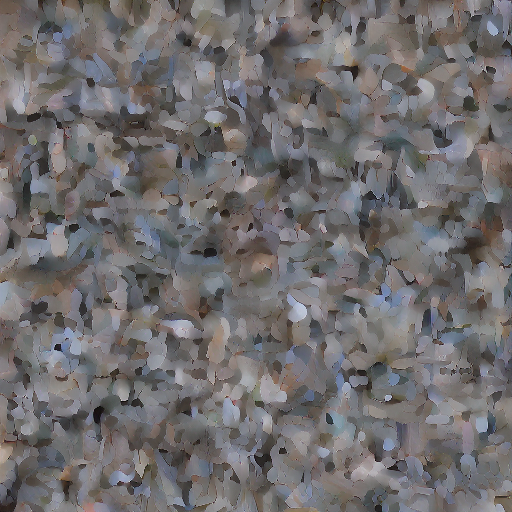

In [38]:
generated_img

# Using Directly with Custom Image and CompVis

In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
vqgan = pipe.vae  # VQGAN is part of the VAE module in the pipeline

In [70]:
from PIL import Image
from torchvision import transforms

image = Image.open("/kaggle/input/image-token/1000092692.jpg").convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

image_tensor = preprocess(image).unsqueeze(0).to(device)
with torch.no_grad():
    latents = vqgan.encode(image_tensor).latent_dist.sample() * 0.18215  # scale factor used in SD

# Decode latents -> image
with torch.no_grad():
    reconstructed_image = vqgan.decode(latents / 0.18215).sample

reconstructed_image = reconstructed_image.clamp(-1, 1)
reconstructed_image = (reconstructed_image + 1) / 2
reconstructed_image = ToPILImage()(reconstructed_image[0].cpu())

reconstructed_image.save("reconstructed.jpg")

In [ ]:
image

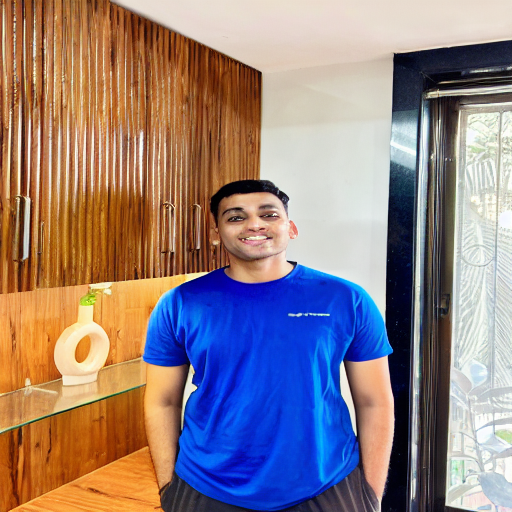

In [77]:
reconstructed_image

In [71]:
image1 = pipe("A dog in the park").images[0]
image2 = pipe("A dog in the park wearing sunglasses").images[0]

# Compare original vs manipulated
image1.save("original_dog.jpg")
image2.save("modified_dog.jpg")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

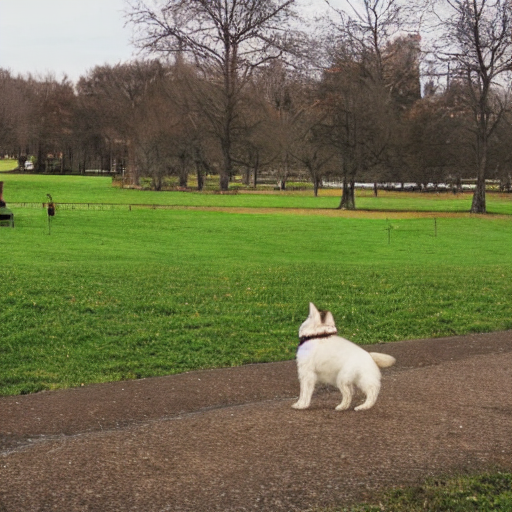

In [78]:
image1

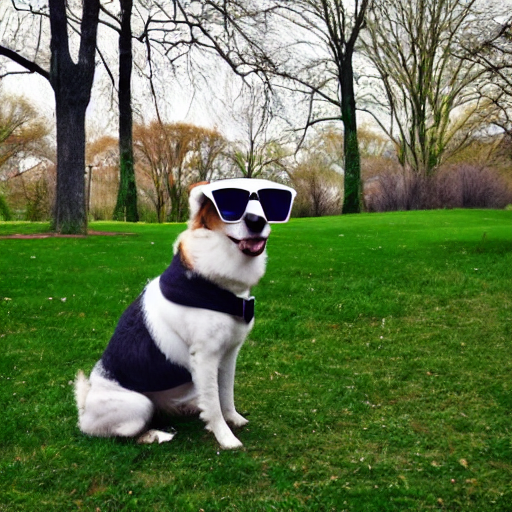

In [79]:
image2

In [72]:
from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [75]:
from PIL import Image
image = Image.open("/kaggle/input/image-token/1000092692.jpg").convert("RGB").resize((512, 512))

prompt = "make a cyberpunk version of the image"
result = pipe(prompt=prompt, image=image, strength=0.7, guidance_scale=7.5).images[0]
result.save("edited_image.jpg")

  0%|          | 0/35 [00:00<?, ?it/s]

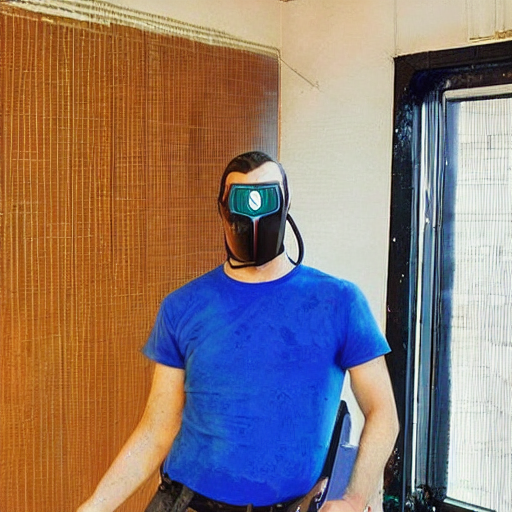

In [76]:
result